In [1]:
import os
from os.path import join
import sys
# from cStringIO import StringIO
import contextlib

import time
import numpy as np
from nipy.algorithms.registration import HistogramRegistration, Rigid
import nibabel as nib


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
import io

In [2]:
# load an example functional image
img = nib.load('tests/GE_func_s1925.nii.gz')

In [3]:
img.get_data().shape

(64, 64, 18, 60)

In [4]:
# create a reference volume and a test volume
affine = img.affine

refVol = img.get_data()[:,:,:,0]
refVol = nib.Nifti1Image(refVol, affine)

In [5]:
affine

array([[  2.99403310e+00,  -1.83411002e-01,  -5.83411753e-02,
         -8.58351822e+01],
       [  1.56465605e-01,   2.81301904e+00,  -1.30558825e+00,
         -5.56155281e+01],
       [  1.06205396e-01,   1.02629399e+00,   3.56818247e+00,
         -8.16833649e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

## estimate motion params between each timepoint and the reference vol
build a function that can be computed on each volume and will return the transformation between 
the current volume and the reference volume. This will allow you to tweak motion estimate parameters
in a way to find the fasted estimate

In [44]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.StringIO()
    yield
    sys.stdout = save_stdout


def estimateMotion(refVol, vol, T_estimate):
    """
    input vols should be nibabel Nifti1 images
    """
    reg = HistogramRegistration(vol, refVol, interp='tri', from_bins=128)
    T = reg.optimize(T_estimate, fhess=fhess)

    return T
    

In [45]:
prevEstimate = Rigid(np.eye(4))
times = []

# loop over each volume
for volIdx in range(img.shape[3]):
    if volIdx == 4:
        refVol = img.get_data()[:,:,:,0]
        refVol = nib.Nifti1Image(refVol, affine)
    elif volIdx > 4:
        thisVol = img.get_data()[:,:,:,volIdx]
        thisVol = nib.Nifti1Image(thisVol, affine)

        # calculate motion
        startTime = time.time()
        with nostdout():
            newT = estimateMotion(refVol, thisVol, prevEstimate)
        
        #print('translation: {}'.format(newT.translation))
        #print('rotation: {}'.format(newT.rotation))
        
        # print time
        endTime = time.time()-startTime
        print('vol {} took: {}ms'.format(volIdx, endTime*1000))
        times.append(endTime)
        
        prevEstimate = newT

print('Average Time: {}'.format(np.mean(times)))


TypeError: configure_optimizer() got multiple values for keyword argument 'fhess'

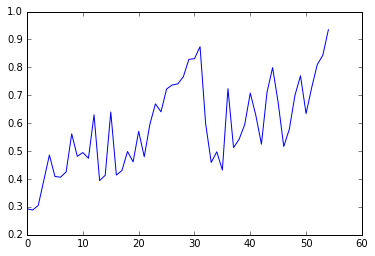

In [35]:
plt.plot(times)

## Goldstandard motion params from FSL


In [39]:
mcf = np.genfromtxt('tests/GE_func_motion.par')

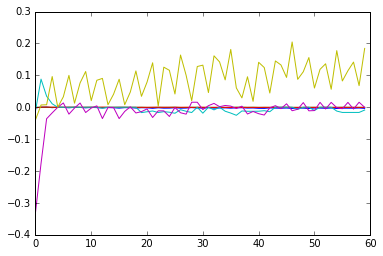

In [41]:
plt.plot(mcf)

In [54]:
reg = HistogramRegistration(testVol2, refVol, from_bins=128, to_bins=128, interp="pv", smooth=10)
start = time.time()
T2 = reg.optimize(T)
print('took: {}'.format(time.time()-start))

Initial guess...
translation : [-0.06089126 -1.30187884  3.57099499]
rotation    : [ -8.38365216e-05  -3.49056598e-05  -3.64426612e-05]

Optimizing using fmin_powell
translation : [-0.06006747 -1.30573526  3.56987801]
rotation    : [ -4.80333827e-05  -3.11382356e-05  -2.46366070e-05]

crl1 = 0.754133006261

Optimization terminated successfully.
         Current function value: -0.754133
         Iterations: 1
         Function evaluations: 80
took: 0.44485926628112793
